### Import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import sys
sys.path.append('./dev/')

In [4]:
from fastai import *
from fastai.vision import *
from ipyexperiments import *

from data_utils import *
from model_utils import *
from metric_utils import *
from loss_utils import *
from recorder import *
seed_everything(42)

### Read Data

In [5]:
data_path = Path('../data/whale/')

In [6]:
sorted(data_path.ls())

[PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/cropped_train'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/old_data'),
 PosixPath('../data/whale/purge-tmp.pkl'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/test'),
 PosixPath('../data/whale/test_bbox.csv'),
 PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/train_bbox.csv')]

In [7]:
# read all csv files
train_df = pd.read_csv(data_path/'train.csv')
train_bbox_df = pd.read_csv(data_path/'train_bbox.csv')
test_bbox_df = pd.read_csv(data_path/'test_bbox.csv')

In [8]:
train_df.shape, train_bbox_df.shape, test_bbox_df.shape

((25361, 2), (25361, 4), (7960, 3))

In [9]:
train_images = grab_image_files(data_path/'train')
test_images = grab_image_files(data_path/'test')
cropped_train_images = grab_image_files(data_path/'cropped_train')
cropped_test_images = grab_image_files(data_path/'cropped_test')
old_train_images = grab_image_files(data_path/'old_data/train')
old_test_images = grab_image_files(data_path/'old_data/test')

In [10]:
(len(train_images), len(cropped_train_images), len(test_images), 
 len(cropped_test_images), len(old_train_images), len(old_test_images))

(25361, 25361, 7960, 7960, 9850, 15610)

In [11]:
train_bbox_df.head(2)

,Image,Id,sizes,keras_model_bbox
0,0000e88ab.jpg,w_f48451c,"[3, 700, 1050]","(233, 160, 852, 417)"
1,0001f9222.jpg,w_c3d896a,"[3, 325, 758]","(0, 79, 744, 239)"


In [12]:
test_bbox_df.head(2)

,Image,sizes,keras_model_bbox
0,93e06c790.jpg,"[3, 375, 1050]","(0, 0, 1024, 357)"
1,617d85eb3.jpg,"[3, 525, 1050]","(15, 100, 1022, 370)"


In [13]:
train_df.head(2)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


### Create train-val known whales

In [14]:
training_df, validation_df = get_training_validation_df(train_df, valid_pct=0.2)

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


In [15]:
training_df.shape, validation_df.shape

((19890, 2), (5471, 2))

In [16]:
# filter out 'new_whale'
training_df = training_df[training_df.Id != 'new_whale']
validation_df = validation_df[validation_df.Id != 'new_whale']

In [17]:
training_df.shape, validation_df.shape

((12158, 2), (3539, 2))

In [18]:
train_valid_df = pd.concat([training_df, validation_df]).reset_index(drop=True)

In [19]:
trn_idxs = np.arange(len(training_df))
val_idxs = np.arange(len(validation_df)) + len(trn_idxs)

### Databunch

In [20]:
itemlist = ImageItemList.from_df(train_valid_df, path=data_path, folder='cropped_train')

In [64]:
bs = 4
size = (448, 448*2)
itemlists = itemlist.split_by_idxs(trn_idxs, val_idxs)
targets = train_valid_df['Id'].values
labellists = itemlists.label_from_lists(targets[trn_idxs], targets[val_idxs])
data = (labellists.transform(get_transforms(max_rotate=15, p_affine=0.5, p_lighting=0.5,
                                            max_warp=0.15, max_zoom=0),
                                            size=size,
                                            resize_method=ResizeMethod.SQUISH)
                                            .databunch(bs=bs))

### Train - No Accumulation

In [39]:
learn = create_cnn(data=data, arch=models.resnet34)

In [40]:
learn.metrics = [accuracy]

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02


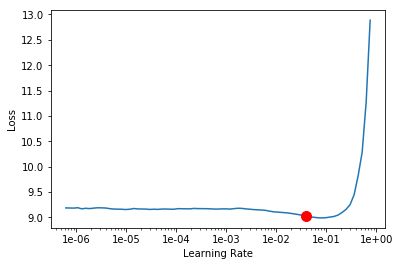

In [34]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 4e-2)

epoch,train_loss,valid_loss,accuracy
1,8.470477,8.761074,0.009325
2,8.233960,8.077899,0.015259
3,7.724330,7.473130,0.036168
4,6.913112,6.730860,0.081379
5,6.135663,6.400362,0.108223


### Train - Accumulate

In [65]:
def get_learner():
    turn_on_accumulation()
    learn = create_cnn(data=data, arch=models.resnet101,lin_ftrs=[2048], metrics=accuracy,
                       callback_fns=[partial(AccumulateStepper, n_step=256)],
                       opt_func=partial(torch.optim.SGD, momentum=0))
    learn.loss_func = CrossEntropyFlat(reduction="sum")
    return learn

In [66]:
learn = get_learner()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


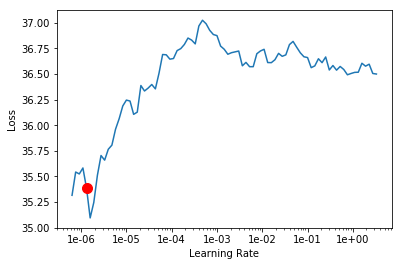

In [68]:
learn.recorder.plot()

In [69]:
learn = get_learner()

In [ ]:
learn.fit_one_cycle(100, 1e-2)

epoch,train_loss,valid_loss,accuracy
